In [1]:
import numpy as np

In [2]:
root_path = "/content/drive/MyDrive/Bot_detection/cresci tweets/cresci 2015"

In [5]:
# genuine_embeddings = np.load(f'{root_path}/genuine_embeddings_20k_no_preprocessing.npy', allow_pickle=True)
# fake_embeddings = np.load(f'{root_path}/fake_embeddings_20k_no_preprocessing.npy', allow_pickle=True)

# genuine_embeddings.shape, fake_embeddings.shape

genuine_embeddings_200k = np.load(f'{root_path}/genuine_embeddings_combined_400k.npy')
fake_embeddings_200k = np.load(f'{root_path}/fake_embeddings_combined_400k.npy')

genuine_embeddings_200k.shape, fake_embeddings_200k.shape

((399321, 768), (395987, 768))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Flatten the embeddings
genuine_embeddings_200k_flat = genuine_embeddings_200k.reshape(genuine_embeddings_200k.shape[0], -1)
fake_embeddings_200k_flat = fake_embeddings_200k.reshape(fake_embeddings_200k.shape[0], -1)

all_embeddings_200k = np.concatenate([genuine_embeddings_200k_flat, fake_embeddings_200k_flat])

In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_embeddings_200k)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster_labels = kmeans.labels_

genuine_cluster_labels_200k = cluster_labels[:len(genuine_embeddings_200k_flat)]
fake_cluster_labels_200k = cluster_labels[len(fake_embeddings_200k_flat):]

genuine_cluster_0 = np.mean(genuine_cluster_labels_200k == 0)
genuine_cluster_1 = np.mean(genuine_cluster_labels_200k == 1)
fake_cluster_0 = np.mean(fake_cluster_labels_200k == 0)
fake_cluster_1 = np.mean(fake_cluster_labels_200k == 1)

genuine_cluster_0, genuine_cluster_1, fake_cluster_0, fake_cluster_1

(0.3743980406740442,
 0.6256019593259559,
 0.38840431632696504,
 0.611595683673035)

In [ ]:
import pickle

with open(f'{root_path}/kmeans_model_200k.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

In [ ]:
import pickle

with open(f'{root_path}/kmeans_model_200k.pkl', 'rb') as file:
    kmeans = pickle.load(file)


cluster_labels = kmeans.labels_

genuine_cluster_labels_200k = cluster_labels[:len(genuine_embeddings_200k_flat)]
fake_cluster_labels_200k = cluster_labels[len(fake_embeddings_200k_flat):]

genuine_cluster_0 = np.mean(genuine_cluster_labels_200k == 0)
genuine_cluster_1 = np.mean(genuine_cluster_labels_200k == 1)
fake_cluster_0 = np.mean(fake_cluster_labels_200k == 0)
fake_cluster_1 = np.mean(fake_cluster_labels_200k == 1)

genuine_cluster_0, genuine_cluster_1, fake_cluster_0, fake_cluster_1

(0.3743980406740442,
 0.6256019593259559,
 0.38840431632696504,
 0.611595683673035)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
all_embeddings_2d = pca.fit_transform(all_embeddings_200k)


In [ ]:
with open(f'{root_path}/pca_model_200k.pkl', 'wb') as file:
    pickle.dump(all_embeddings_2d, file)

In [ ]:
with open(f'{root_path}/pca_model_200k.pkl', 'rb') as file:
    all_embeddings_2d = pickle.load(file)

In [ ]:
# Define which cluster is the "genuine" cluster and which is the "fake" cluster
genuine_cluster = 0 if genuine_cluster_0 > genuine_cluster_1 else 1
fake_cluster = 1 - genuine_cluster

# Calculate misclassified points
misclassified_genuine = np.where(genuine_cluster_labels_200k == fake_cluster)
misclassified_fake = np.where(fake_cluster_labels_200k == genuine_cluster)

print(f"Number of misclassified genuine points: {len(misclassified_genuine[0])}")
print(f"Number of misclassified fake points: {len(misclassified_fake[0])}")


Number of misclassified genuine points: 149505
Number of misclassified fake points: 244223


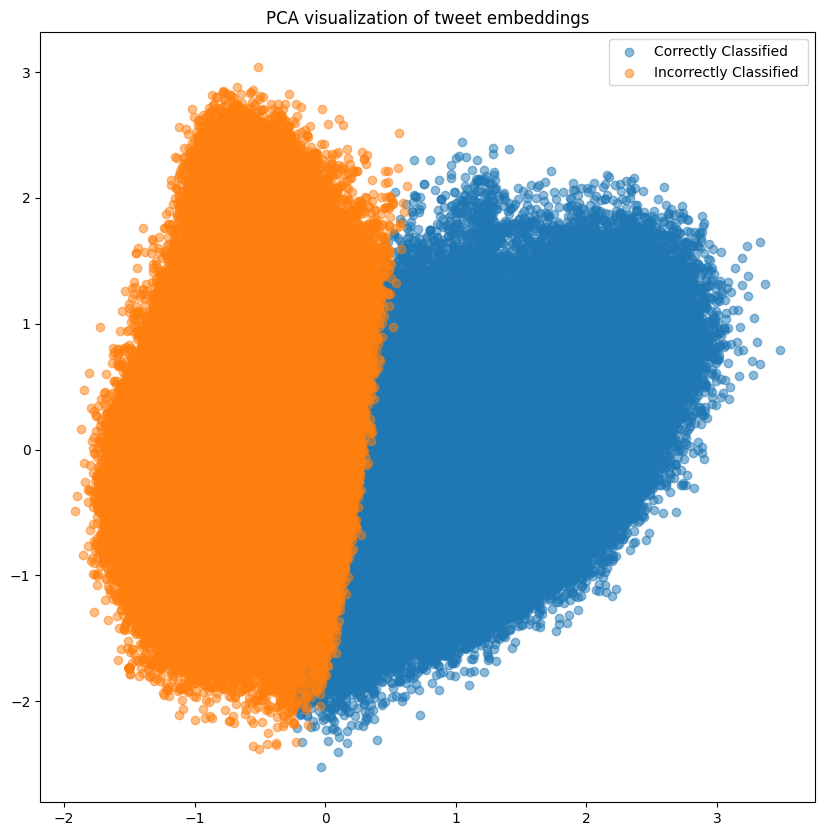

In [ ]:
import matplotlib.pyplot as plt
# Split your data into two sets based on the cluster labels
cluster_0 = all_embeddings_2d[:len(genuine_embeddings_200k_flat)][genuine_cluster_labels_200k == 0]
cluster_1 = all_embeddings_2d[:len(genuine_embeddings_200k_flat)][genuine_cluster_labels_200k == 1]

plt.figure(figsize=(10, 10))

# Create a scatter plot for each cluster
plt.scatter(cluster_0[:, 0], cluster_0[:, 1], marker='o', alpha=0.5, label='Correctly Classified')
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], marker='o', alpha=0.5, label='Incorrectly Classified ')

plt.legend()
plt.title('PCA visualization of tweet embeddings')
plt.show()


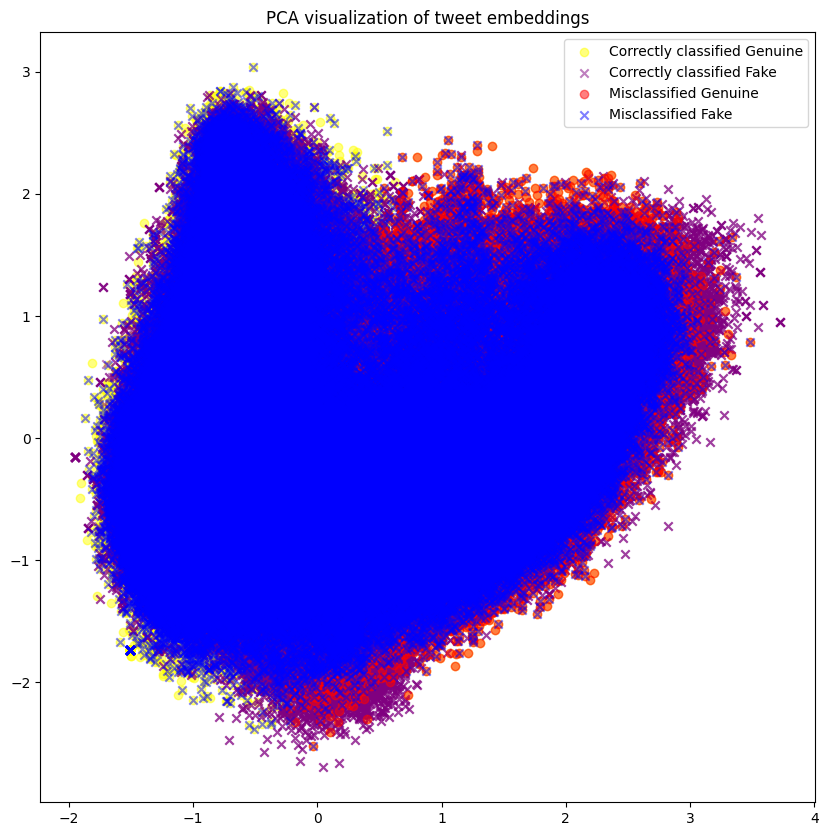

In [ ]:
plt.figure(figsize=(10, 10))

# Plot correctly classified points

plt.scatter(all_embeddings_2d[:len(genuine_embeddings_200k_flat), 0], all_embeddings_2d[:len(genuine_embeddings_200k_flat), 1],
            c='yellow', marker='o', alpha=0.5, label='Correctly classified Genuine')
plt.scatter(all_embeddings_2d[len(fake_embeddings_200k_flat):, 0], all_embeddings_2d[len(fake_embeddings_200k_flat):, 1],
            c='purple', marker='x', alpha=0.5, label='Correctly classified Fake')

# Overlay misclassified points
plt.scatter(all_embeddings_2d[misclassified_genuine, 0], all_embeddings_2d[misclassified_genuine, 1],
            c='red', marker='o', alpha=0.5, label='Misclassified Genuine')
plt.scatter(all_embeddings_2d[misclassified_fake, 0], all_embeddings_2d[misclassified_fake, 1],
            c='blue', marker='x', alpha=0.5, label='Misclassified Fake')

plt.legend()
plt.title('PCA visualization of tweet embeddings')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, silhouette_score
from sklearn.utils import resample
import numpy as np

# Select a random sample of 40000 instances
n_samples = 40000
sampled_embeddings, sampled_cluster_labels = resample(all_embeddings_200k, cluster_labels, n_samples=n_samples, replace=False, random_state=0)

actual_labels = np.concatenate([np.zeros(len(genuine_embeddings_200k_flat)), np.ones(len(fake_embeddings_200k_flat))])

conf_matrix = confusion_matrix(actual_labels, cluster_labels)

if genuine_cluster_0 > genuine_cluster_1:
    predicted_labels = cluster_labels
else:
    predicted_labels = 1 - cluster_labels
f1 = f1_score(actual_labels, predicted_labels)

# Calculate the silhouette score for the sampled data
# silhouette = silhouette_score(sampled_embeddings, sampled_cluster_labels, n_jobs=-1)

conf_matrix, f1
# conf_matrix, f1, silhouette


(array([[149505, 249816],
        [155005, 240982]]),
 0.4425572129502339)

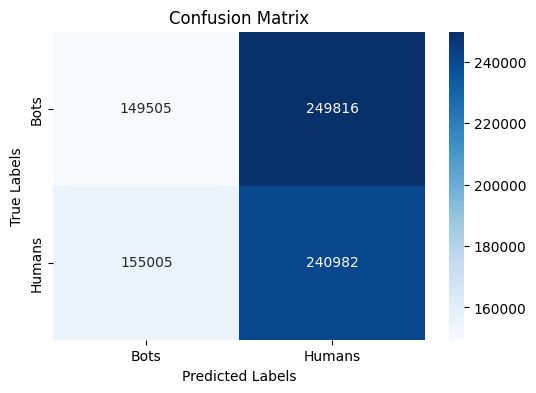

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
#conf_matrix = confusion_matrix(genuine_train_labels, predictions_new)

# Define class labels (e.g., 'Positive' and 'Negative')
class_labels = ['Bots', 'Humans']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
correct_classifications = np.sum(predicted_labels == actual_labels)
incorrect_classifications = np.sum(predicted_labels != actual_labels)
total_points = len(actual_labels)

correct_percentage = (correct_classifications / total_points) * 100
incorrect_percentage = (incorrect_classifications / total_points) * 100

print(f'correct: {round(correct_percentage, 2)}%\nincorrect: {round(incorrect_percentage, 2)}%')

correct: 50.9%
incorrect: 49.1%


In [ ]:
i = 0
j = 0
for x in predicted_labels:
  if x == 0:
    i += 1
  else:
    j += 1

print("predicted humans:", i)
print("predicted bot:", j)

predicted humans: 490798
predicted bot: 304510


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
print("Accuracy Score for Train Bot Set:", accuracy_score(actual_labels, predicted_labels))
print("Precision Score for Train Bot Set:", precision_score(actual_labels, predicted_labels))
print("Recall Score for Train Bot Set:", recall_score(actual_labels, predicted_labels))
print("F1 Score for Train Bot Set:", f1_score(actual_labels, predicted_labels))

Accuracy Score for Train Bot Set: 0.5090116030518994
Precision Score for Train Bot Set: 0.5090309021050212
Recall Score for Train Bot Set: 0.3914396179672565
F1 Score for Train Bot Set: 0.4425572129502339
